# Tutorial of scutquant(2024.2)

__Process:__

0. Data (Get data from tushare)

1. Make prediction label

2. Make alphas (因子)

3. Data clean (数据清洗, Deal with abnormal data -> cross sectional zscore normalization(cs_zscore) -> Split data)

4. Model training & make prediction

5. IC test

6. Group test (分位数组合测试)

7. Vectorized backtest (向量化回测)

8. Event-driven backtest (事件驱动型回测)

__Pool:__ CSI300 constituent stocks

__Time range:__ 2015-01-05 ~ 2024-12-02

下面是一个简单的教程，我们将使用scutquant的scutquant、alpha、report和executor模块完成一个从用原始数据构建因子，特征工程和数据清洗，划分数据集，使用模型做信号合成，并根据预测值进行模拟实盘回测的全过程 :)

用到的各模块的主要功能如下:  

* scutquant: 主要负责除了因子构建以外的数据处理，包括数据清洗，数据集划分和pca等等，也提供一些可直接调用的简单的模型（主要是树模型和线性模型）
* alpha: 主要负责与因子相关的数据处理，并批量生成因子（对单因子的精细处理可通过底层的operators模块实现），提供单因子回测函数
* report: 主要负责对计算结果生成报告，无论是因子数据（single_factor_ana）还是分组报告（group_return_ana）还是整个回测的报告
* executor: 根据预测值和策略按datetime（可以是任何频率的数据）执行回测，并返回一个executor对象，其中包含了用户的账户对象user_account，内含回测的全部细节

In [1]:
# 导入需要用到的库
import pandas as pd
import scutquant.scutquant as q
from scutquant import alpha, report, executor

样例数据集只有基础的价量数据，以面板数据的形式呈现. 当需要额外数据构建因子时(例如需要构建市场因子Rm), 就需要读取supplemental data. 当补充数据为时序数据时，可以使用join_data函数将其合并到数据集中；当补充数据为各个股票的截面数据时，可以使用join_data_by_code按股票代码将数据合并到数据集中

In [2]:
# 读取数据
df = pd.read_csv("data/stock_data_after2015.csv")
df["datetime"] = pd.to_datetime(df["datetime"])
df.set_index(["datetime", "instrument"], inplace=True)
df

open   high    low  close  pre_close  change  pct_chg  \
datetime   instrument                                                           
2015-01-05 000001.SZ   15.99  16.28  15.60  16.02      15.84    0.18   1.1400   
           000002.SZ   14.39  15.29  14.22  14.91      13.90    1.01   7.2700   
           000024.SZ   28.75  29.03  27.50  28.22      26.39    1.83   6.9300   
           000027.SZ   11.23  11.60  11.11  11.38      11.16    0.22   1.9700   
           000039.SZ   22.00  22.53  21.43  22.10      21.89    0.21   0.9600   
...                      ...    ...    ...    ...        ...     ...      ...   
2024-11-28 688303.SH   28.19  29.16  27.81  28.19      28.02    0.17   0.6067   
           688363.SH   58.70  59.14  57.82  57.84      58.69   -0.85  -1.4483   
           688396.SH   50.35  50.85  49.50  49.77      50.25   -0.48  -0.9552   
           688599.SH   24.19  24.62  24.04  24.20      24.23   -0.03  -0.1238   
           688981.SH   88.20  90.30  86.83  87.08      88.00   -0.92  -1.0455   

                           volume        amount     label  
datetime   instrument                                      
2015-01-05 000001.SZ   2860436.43  4.565388e+06 -0.019000  
           000002.SZ   6560835.70  9.700712e+06 -0.009100  
           000024.SZ   1077245.66  3.073929e+06  0.003700  
           000027.SZ    477145.19  5.448362e+05  0.040400  
           000039.SZ    456487.82  1.002534e+06 -0.026000  
...                           ...           ...       ...  
2024-11-28 688303.SH    102019.26  2.911334e+05 -0.001042  
           688363.SH     20546.03  1.201360e+05  0.019608  
           688396.SH     61295.11  3.076616e+05 -0.000199  
           688599.SH    131984.82  3.208228e+05  0.020123  
           688981.SH    611101.37  5.379090e+06 -0.006770  

[706432 rows x 10 columns]

**关于目标值:** 为了避免数据泄露和其它各种问题，我们构建的目标值应尽量与已知数据无关(即$y_t$无法用已知的数据${X_t, X_{t-1}, ...}$计算得到). 这里我们选择$label = \frac{close_{-2}}{close_{-1}} - 1$, 即T时刻需要预测的目标值是T+2相对于T+1的收益率, 现实意义是在今天(T)作出预测, 并在明天(T+1)以收盘价开仓, 后天(T+2)以收盘价平仓  

**关于因子:** 参考alpha模块中的make_factors()和alpha360(), 前者主要为技术指标, 后者是原始量价数据的滞后项除单位, 目的是让模型在张成的360维空间中自行发掘因子

In [4]:
df[df.index.get_level_values(1) == "000001.SZ"].shift(-2)

,,open,high,low,close,pre_close,change,pct_chg,volume,amount,label
datetime,instrument,,,,,,,,,,
2015-01-05,000001.SZ,15.56,15.83,15.30,15.48,15.78,-0.30,-1.9000,1700120.67,2.634796e+06,0.008000
2015-01-06,000001.SZ,15.50,15.57,14.90,14.96,15.48,-0.52,-3.3600,1407714.21,2.128003e+06,-0.020600
2015-01-07,000001.SZ,14.90,15.87,14.71,15.08,14.96,0.12,0.8000,2508500.23,3.835378e+06,-0.006100
2015-01-08,000001.SZ,14.87,15.05,14.50,14.77,15.08,-0.31,-2.0600,1553290.86,2.293105e+06,0.008900
2015-01-09,000001.SZ,14.65,14.90,14.61,14.68,14.77,-0.09,-0.6100,816874.77,1.204987e+06,0.036500
...,...,...,...,...,...,...,...,...,...,...,...
2024-11-22,000001.SZ,11.18,11.31,11.14,11.27,11.18,0.09,0.8050,831078.20,9.337339e+05,-0.004390
2024-11-25,000001.SZ,11.24,11.39,11.15,11.39,11.27,0.12,1.0648,895178.05,1.010002e+06,0.003527
2024-11-26,000001.SZ,11.39,11.42,11.32,11.34,11.39,-0.05,-0.4390,733168.54,8.331213e+05,0.000879


In [3]:
# 构造目标值
df["label"] = df["pct_chg"].groupby("instrument").shift(-2) / 100
df = df.dropna() 
df

open   high    low  close  pre_close  change  pct_chg  \
datetime   instrument                                                           
2015-01-05 000001.SZ   15.99  16.28  15.60  16.02      15.84    0.18   1.1400   
           000002.SZ   14.39  15.29  14.22  14.91      13.90    1.01   7.2700   
           000024.SZ   28.75  29.03  27.50  28.22      26.39    1.83   6.9300   
           000027.SZ   11.23  11.60  11.11  11.38      11.16    0.22   1.9700   
           000039.SZ   22.00  22.53  21.43  22.10      21.89    0.21   0.9600   
...                      ...    ...    ...    ...        ...     ...      ...   
2024-11-26 688303.SH   27.40  28.48  27.10  27.21      26.93    0.28   1.0397   
           688363.SH   57.40  58.00  57.03  57.27      57.40   -0.13  -0.2265   
           688396.SH   49.49  49.95  48.90  49.20      49.60   -0.40  -0.8065   
           688599.SH   23.49  24.36  23.39  23.55      23.49    0.06   0.2554   
           688981.SH   85.97  86.66  85.03  85.10      86.16   -1.06  -1.2303   

                           volume        amount     label  
datetime   instrument                                      
2015-01-05 000001.SZ   2860436.43  4.565388e+06 -0.019000  
           000002.SZ   6560835.70  9.700712e+06 -0.009100  
           000024.SZ   1077245.66  3.073929e+06  0.003700  
           000027.SZ    477145.19  5.448362e+05  0.040400  
           000039.SZ    456487.82  1.002534e+06 -0.026000  
...                           ...           ...       ...  
2024-11-26 688303.SH    101058.20  2.808356e+05  0.006067  
           688363.SH     14940.06  8.592522e+04 -0.014483  
           688396.SH     44512.96  2.197870e+05 -0.009552  
           688599.SH    159875.82  3.812347e+05 -0.001238  
           688981.SH    353635.42  3.031752e+06 -0.010455  

[705156 rows x 10 columns]

In [4]:
# 构造因子
# X = alpha.qlib158(df)
# X = pd.concat([X, df[["label"]]], axis=1)
# X

In [5]:
X = alpha.make_factors(df)
X = pd.concat([X, df[["label"]]], axis=1)
X

pvd5     pvd10     pvd20     pvd30     label
datetime   instrument                                                  
2015-01-05 000001.SZ        NaN       NaN       NaN       NaN -0.019000
           000002.SZ        NaN       NaN       NaN       NaN -0.009100
           000024.SZ        NaN       NaN       NaN       NaN  0.003700
           000027.SZ        NaN       NaN       NaN       NaN  0.040400
           000039.SZ        NaN       NaN       NaN       NaN -0.026000
...                         ...       ...       ...       ...       ...
2024-11-26 688303.SH  -0.648909 -0.461935 -0.754787 -0.777352  0.006067
           688363.SH  -0.483157 -0.899811 -0.688904 -0.672778 -0.014483
           688396.SH  -0.398509 -0.680493 -0.664527 -0.546691 -0.009552
           688599.SH   0.106374 -0.621044 -0.696644 -0.587466 -0.001238
           688981.SH  -0.184200 -0.458440 -0.394725 -0.239660 -0.010455

[705156 rows x 5 columns]

# 数据清洗

1. 统计缺失值比例
2. 因子(X)与标签(label)分离
3. 对label降采样(剔除唯一值占比小于unique_threshold的日期)并剔除inf
4. 对X,对inf的因子值前向填充,剔除空值
5. 3 $\sigma$ 缩尾
6. 截面zscore标准化

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 705156 entries, (Timestamp('2015-01-05 00:00:00'), '000001.SZ') to (Timestamp('2024-11-26 00:00:00'), '688981.SH')
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   pvd5    702607 non-null  float64
 1   pvd10   699422 non-null  float64
 2   pvd20   693052 non-null  float64
 3   pvd30   686682 non-null  float64
 4   label   705156 non-null  float64
dtypes: float64(5)
memory usage: 29.7+ MB
None
X_mis= 1.1021958261717975
original label:


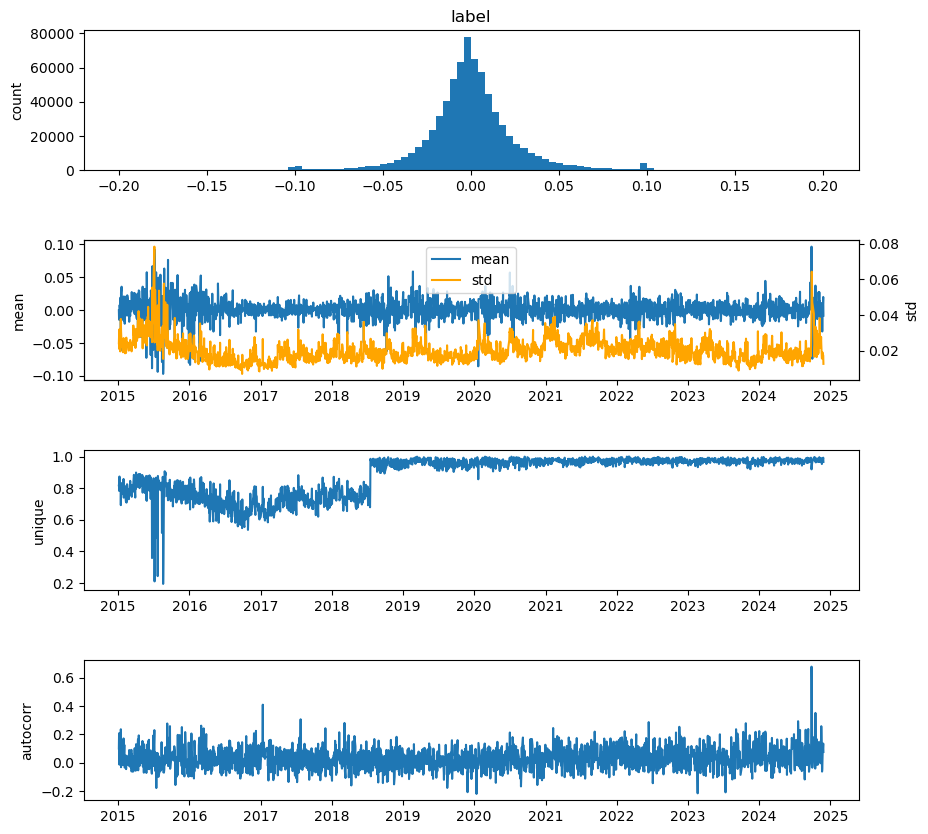

label processed:


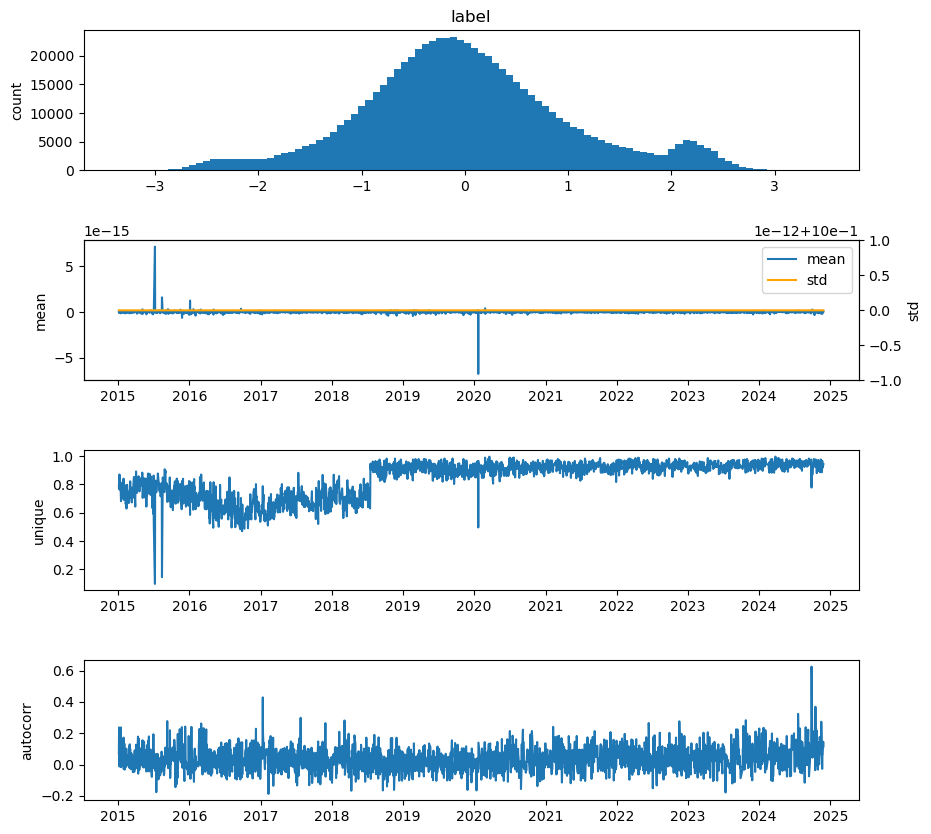

process dataset done
split data done 

all works done 



In [ ]:
split_params = {
    "test_start_date": "2020-01-01",
    "split_method": "split_by_date",
    "split_kwargs":{
        "train_end_date": "2017-12-31",
        "valid_end_date": "2019-12-31"
    }
}
# 使用auto_process按照标准流程进行数据处理, 并按split_params拆分出训练集、验证集和测试集
result = q.auto_process(X, "label", split_params=split_params, unique_threshold=0.5)

X_train, y_train, X_valid, y_valid, X_test, y_test = result["X_train"], result["y_train"], result["X_valid"], result["y_valid"], result["X_test"], result["y_test"]

Epoch: 1 loss: 1.0366498397401542 val_loss: 1.021514202290247 val_ic: 0.01616430943254207
Epoch: 2 loss: 0.9954707995919156 val_loss: 0.9973262913173229 val_ic: 0.034088817993784645
Epoch: 3 loss: 0.9904195743158829 val_loss: 0.9965644005142933 val_ic: 0.035843819564678595
Epoch: 4 loss: 0.9895233906990241 val_loss: 0.9963820654998325 val_ic: 0.036740968728924954
Epoch: 5 loss: 0.9890507208414314 val_loss: 0.9961729896631574 val_ic: 0.03711130490251774
Epoch: 6 loss: 0.9886777216737921 val_loss: 0.9961483671924661 val_ic: 0.03734266350905887
Epoch: 7 loss: 0.9883429153891634 val_loss: 0.9961335078891542 val_ic: 0.03734109204044246
Epoch: 8 loss: 0.9880302851850337 val_loss: 0.9961873970971705 val_ic: 0.036940866515702074
Epoch: 9 loss: 0.9877246197590158 val_loss: 0.9962387769129242 val_ic: 0.03653668425118906
Epoch: 10 loss: 0.9874090368097479 val_loss: 0.9963583920525819 val_ic: 0.03625969083939566


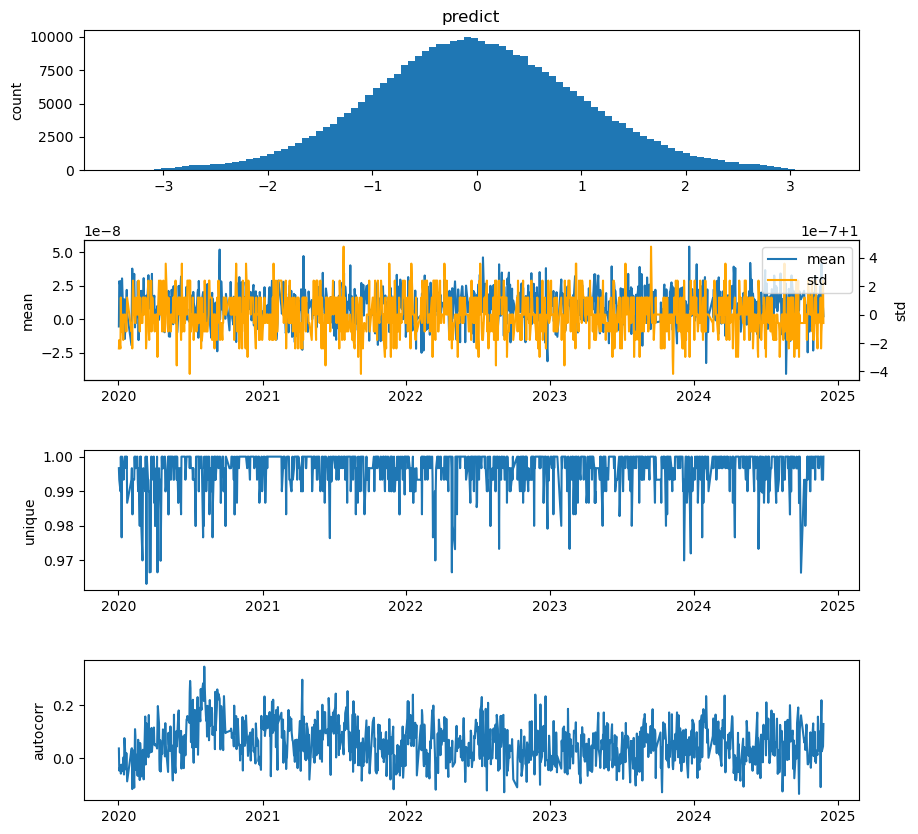

In [ ]:
# 拟合模型
from scutquant import models


# model = models.MLP(input_shape=len(X_train.columns), hidden_shape=50)
model = models.CNN(input_channels=len(X_train.columns), hidden_channels=50, output_channels=20)
model.fit(X_train, y_train, X_valid, y_valid)
pred = model.predict_pandas(X_test).to_frame(name="predict")

# RNNs
# X_train, X_valid, X_test = q.adjust_data_for_rnn(X_train, X_valid, X_test, y_valid, timestep = 3)
# model = models.GRU(input_shape=len(X_train.columns), hidden_shape=50, timesteps=3)
# model = models.LSTM(input_shape=len(X_train.columns), hidden_shape=50, timesteps=3)
# model.fit(X_train, y_train, X_valid, y_valid, adjusted=True)
# pred = model.predict_pandas(X_test).to_frame(name="predict")

# GNNs
# edges = models.from_series_to_edge(y_train)  # 主要多了这步, 需要自己构建edge_index
# edges = models.make_rolling_corr_matrix(y_train)   # 动态图
# model = models.GraphSage(input_channels=50, hidden_channels=20, output_channels=10)
# model.fit(X_train, y_train, X_valid, y_valid, edge_index=edges)
# pred = model.predict_pandas(X_test, edge_index=edges).to_frame(name="predict")

# model.save()

pred["predict"] = alpha.cs_zscore(alpha.mad_winsor(pred["predict"]))

report.single_factor_ana(pred["predict"])

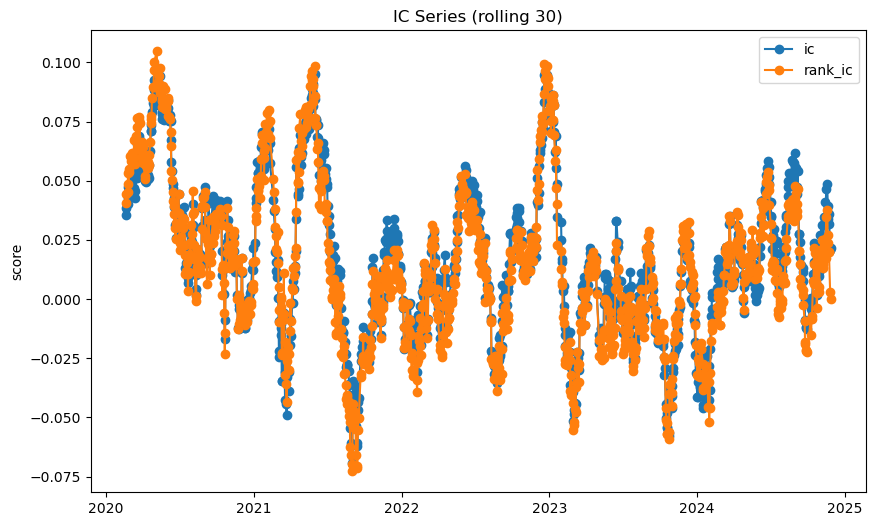

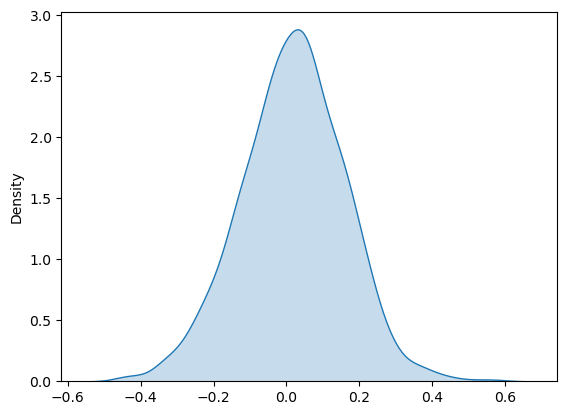

ic= 0.016644972826049386 icir= 0.11674734415492788 rank_ic= 0.013443444286469743 rank_icir= 0.08886468854681881


In [8]:
df_test = df[df.index.isin(pred.index)]
target = df_test["label"]  # 真实收益率
# 使用IC评判拟合优度
ic, icir, rank_ic, rank_icir = q.ic_ana(pred, target, groupby='datetime')
print('ic=', ic, 'icir=', icir, 'rank_ic=', rank_ic, 'rank_icir=', rank_icir)

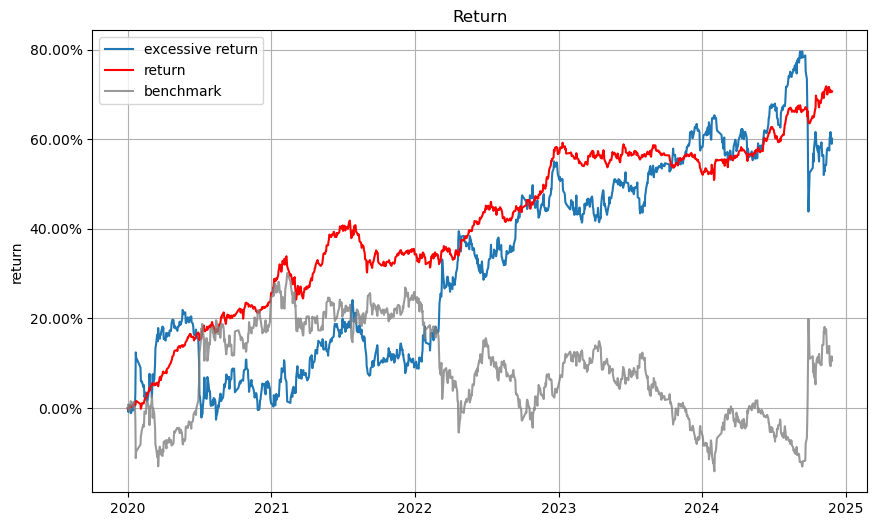

<Figure size 640x480 with 0 Axes>

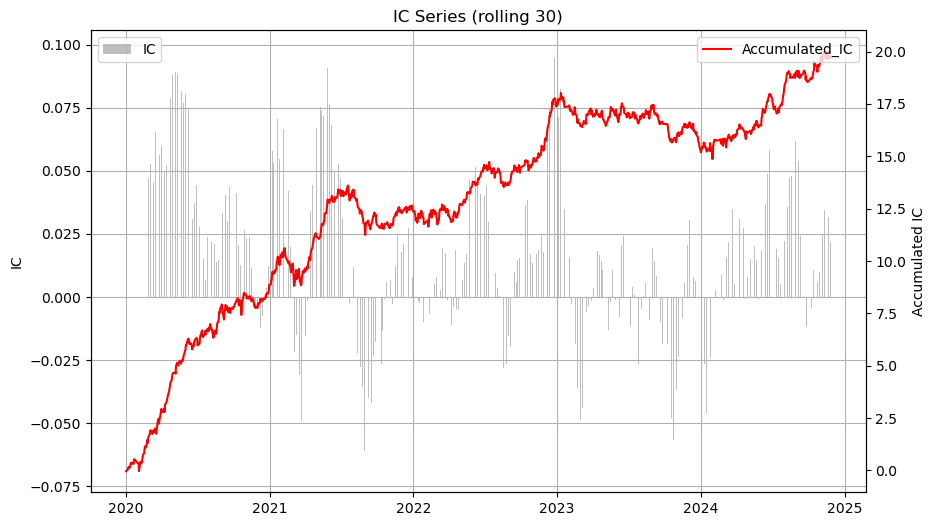

In [9]:
# 向量化回测
result_df, result_summary = alpha.get_factor_metrics(pred["predict"], target, to_df=True)

In [10]:
result_df

,ic,accumulated_ic,return,benchmark,excess_return,drawdown,excess_return_drawdown,turnover
datetime,,,,,,,,
2020-01-02,-0.040043,-0.040043,-0.001139,0.000164,-0.001303,0.000000,-0.000000,1.000000
2020-01-03,0.017905,-0.022138,-0.000785,0.007938,-0.008722,0.000000,5.694804,1.021782
2020-01-06,0.053771,0.031633,0.000483,-0.006597,0.007080,0.000000,0.000000,1.073038
2020-01-07,0.068852,0.100484,0.002104,0.005777,-0.003673,0.000000,-1.518813,0.926968
2020-01-08,0.026820,0.127304,0.002632,0.004794,-0.002162,0.000000,-1.305382,0.990361
...,...,...,...,...,...,...,...,...
2024-11-20,-0.220480,19.699193,0.705168,0.101621,0.603547,-0.007556,-0.241927,1.101936
2024-11-21,-0.020572,19.678621,0.704335,0.098446,0.605889,-0.008041,-0.238985,0.845497
2024-11-22,0.128374,19.806996,0.709467,0.093635,0.615831,-0.005054,-0.226497,1.139172


In [11]:
result_summary

,ic_mean,icir,t-stat,max_drawdown,excess_return_max_drawdown,sharpe,ir,fitness
0,0.016645,0.116747,4.022281,-0.081736,-2.618405,2.347572,1.464205,1.491985


In [12]:
# 以下为回测部分
# 将预测值处理成回测需要的格式(需要知道预测值"predict", 交易价格price和交易量volume), 注意因为是第二天才开仓, 所以price做了shift(-1)
pred = executor.prepare(pred, df_test, price='close', volume='volume', real_ret=target)
pred

predict  price      volume         R
time       code                                            
2020-01-02 000001.SZ -0.508915  17.18  1530231.87 -0.006403
           000002.SZ  2.237789  32.05  1012130.40 -0.016849
           000063.SZ  1.329009  36.55  1014254.88  0.004104
           000069.SZ  0.817835   7.75   779758.69  0.002581
           000100.SZ  0.054414   4.65  3649741.48 -0.008602
...                        ...    ...         ...       ...
2024-11-25 688303.SH -2.643662  27.21    81132.48  0.029768
           688363.SH -0.813327  57.27    22231.19  0.024795
           688396.SH -0.717882  49.20    70488.70  0.021341
           688599.SH -2.254469  23.55   183054.23  0.028875
           688981.SH  0.749087  85.10   769059.09  0.034078

[354656 rows x 4 columns]

Accuracy of Prediction: 0.533542362176306


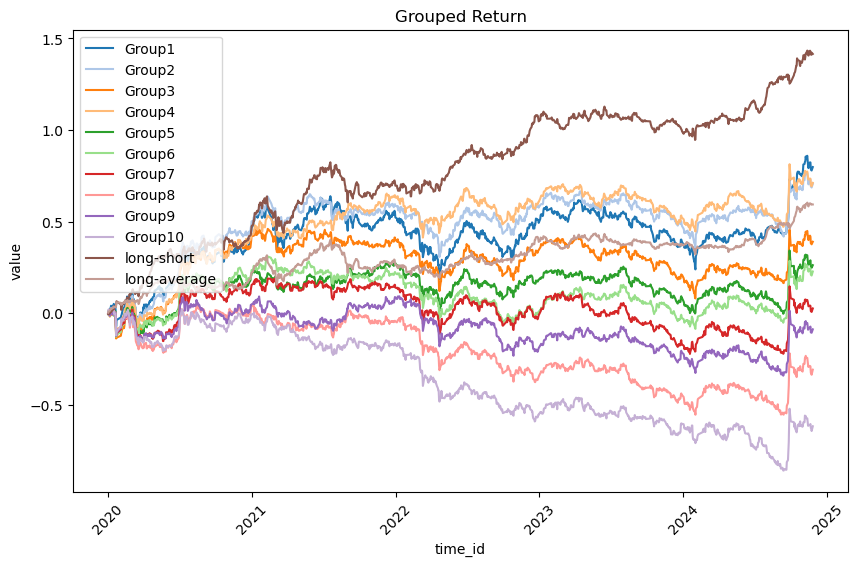

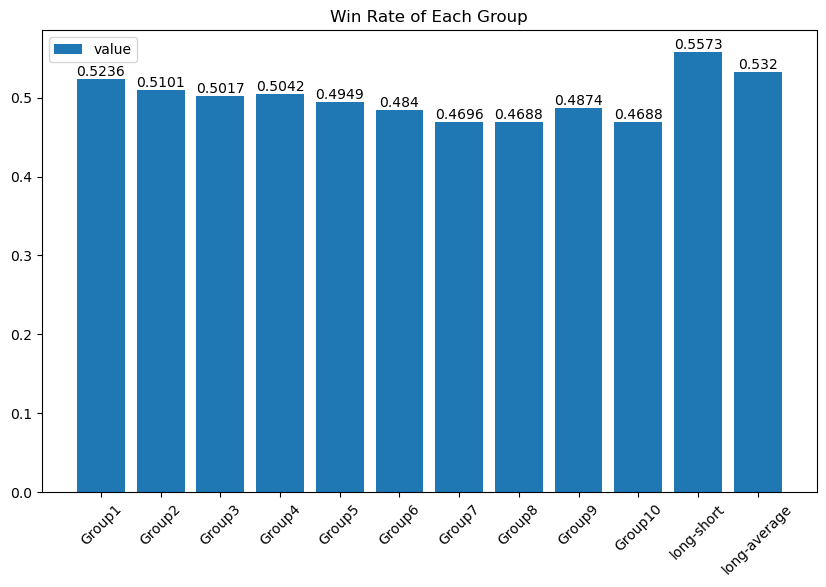

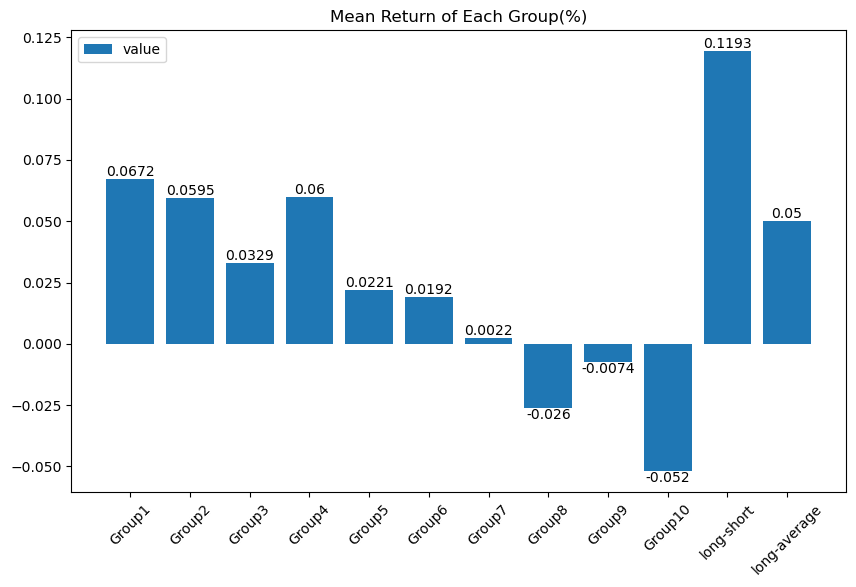

In [13]:
# 如果出现明显的分层, 则说明因子有良好的选股能力
report.group_return_ana(pred, target)

In [14]:
backtest = {
    "strategy": {
        "class": "QlibTopKStrategy",  # 做多预测值前k*100%的股票, 做空后k*100%的股票.
        "kwargs": {
            "n_start": 50, 
            "k": 0.1,
            "equal_weight": True  # qlib选择等权持有,但某些情况下加权比等权收益更好 
        }
    },
    "account": {
        "cash": 2e8,  # 初始资金
    }, 
    "trade_params": {
        "cost_buy": 0.0005,
        "cost_sell": 0.0015,  
        "min_cost": 5,
    }
}
strategy, account, trade_params = backtest["strategy"], backtest["account"], backtest["trade_params"]
exe = executor.Executor(strategy, account, trade_params)
exe.execute(data=pred, verbose=0)  # verbose=1时，按时间输出买卖指令

Annualized Return: -0.07915267448478613
Annualized Volatility: 0.11507246771636413
Annualized Return(Benchmark): 0.023834308290359152
Annualized Volatility(Benchmark): 0.048465298427364537 

Cumulative Rate of Return: -0.3218709123354352
Cumulative Rate of Return(Benchmark): 0.11733919409042959
Cumulative Excess Rate of Return: -0.4392101064258648 

Max Drawdown: -0.6396214857874182
Max Drawdown(Benchmark): -0.33904368683822295
Max Drawdown(Excess Return): -0.6009662084314755 

Sharpe Ratio: -0.11501817768141302
Sortino Ratio: -0.5787561274156611
Information Ratio: -0.6315403171351565 

Beta: 1.9022765680376312
Alpha: -0.18684373051484468
Epsilon: 0.14945129707290472
Profitable Days(%): 0.33136593591905567


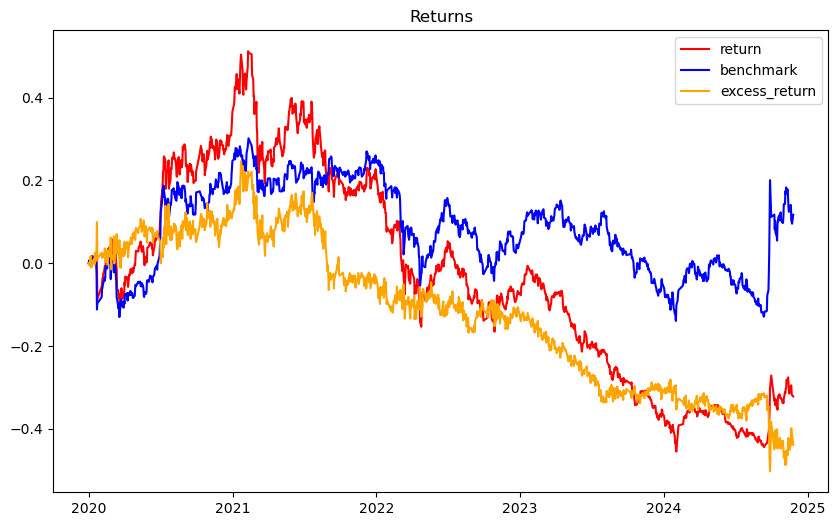

<Figure size 640x480 with 0 Axes>

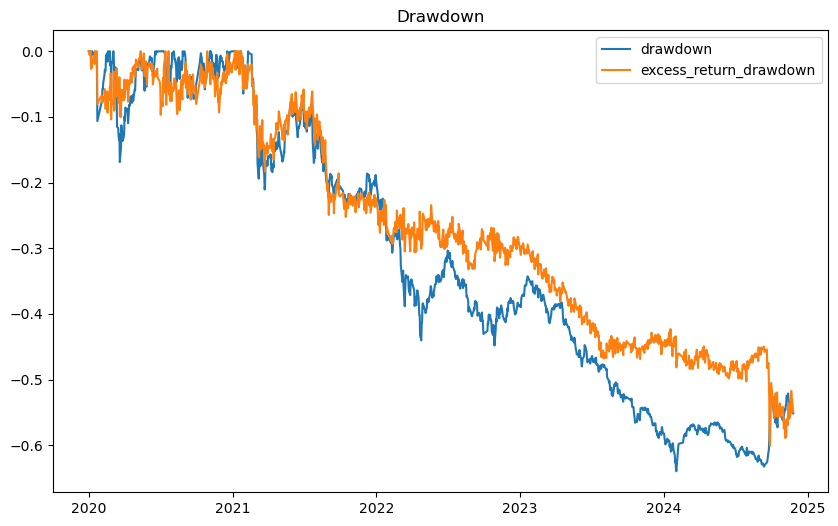

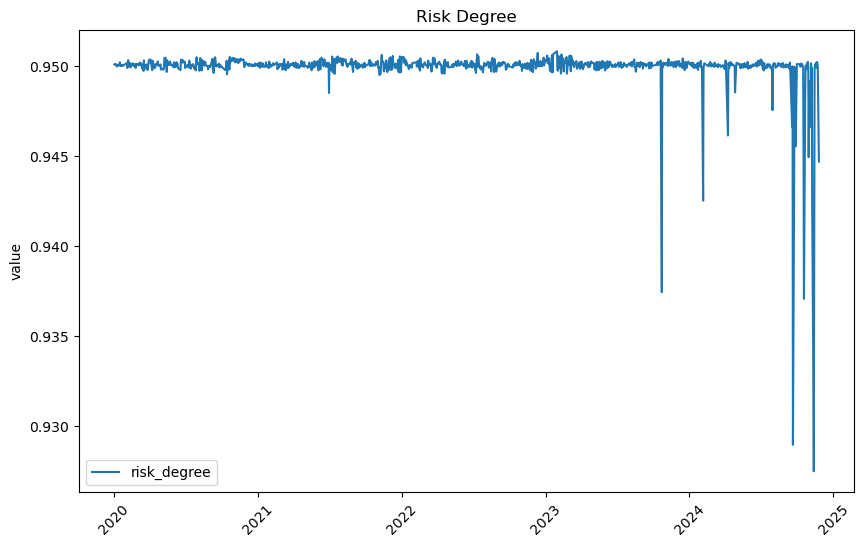

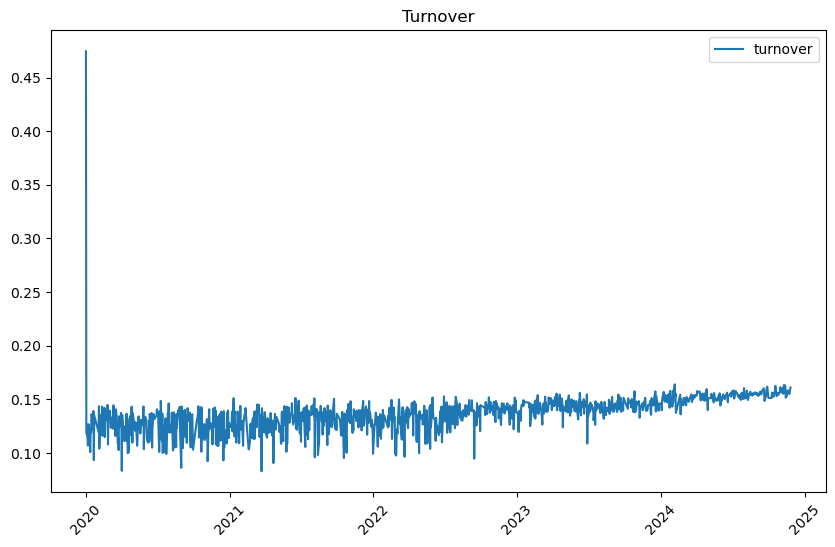

In [15]:
# 报告回测结果
user_account, benchmark = exe.user_account, exe.benchmark
report.report_all(user_account, benchmark, freq=1, time=exe.time)  # 无风险收益率默认为年化3%，可以通过参数rf调节

In [16]:
# user_account.position